In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns

In [27]:
# Create a function to convert Celcius to the nearest 10th of a degree to Fahrenheit
def convert_c_10th_to_f(temp: int) -> float:
    # Convert C to the nearest tenth to C
    c_temp = temp/10
    # Convert C to F
    f_temp = (c_temp * 9/5) + 32
    
    return f_temp

In [28]:
# Import the data
filename = 'PhoenixWeather.csv'
df = pd.read_csv(filename, usecols=['DATE', 'PRCP', 'TMAX'])
# Rename the columns
df.columns = ['Date', 'Precipitation_mm', 'Temp_C']
# Clean up the NaN values
df.fillna(0, inplace=True)
# Convert the date column to a Date type
df['Date'] = pd.to_datetime(df['Date'])
# Convert the temperatures to Fahrenheit
df['Temp_F'] = df['Temp_C'].apply(convert_c_10th_to_f)
# Convert mm to the nearest 10th to inches
df['Precipitation_in'] = df['Precipitation_mm']/254
# Only get the years 1970 and up
df = df[df['Date'] >= '1970']
# Preview the data
df.head()

,Date,Precipitation_mm,Temp_C,Temp_F,Precipitation_in
11471,1970-01-01,0.0,139.0,57.02,0.0
11472,1970-01-02,0.0,128.0,55.04,0.0
11473,1970-01-03,0.0,150.0,59.00,0.0
11474,1970-01-04,0.0,161.0,60.98,0.0
11475,1970-01-05,0.0,144.0,57.92,0.0


In [29]:
# Get the average temperature for each month
average_temps = df.groupby(df['Date'].dt.strftime('%Y-%m'))['Temp_F'].mean().reset_index()
# Convert the Date column to a datetime object
average_temps['Date'] = pd.to_datetime(average_temps['Date'])
# Preview the data
average_temps.head()

,Date,Temp_F
0,1970-01-01,66.519355
1,1970-02-01,74.698571
2,1970-03-01,72.575484
3,1970-04-01,80.576000
4,1970-05-01,95.865161


In [30]:
# Get the number of days with 100+ temps per year
days_over_100 = df.groupby(df['Date'].dt.year)['Temp_F'].agg(lambda x: x.ge(100).sum())
# Get the number of days with 110+ temps per year
days_over_110 = df.groupby(df['Date'].dt.year)['Temp_F'].agg(lambda x: x.ge(110).sum())
hundred_temperatures = pd.concat({
    'Days_Over_100':days_over_100, 
    'Days_Over_110': days_over_110
}, axis=1)
# Reset the index
hundred_temperatures.reset_index(inplace=True)
# Preview the data
hundred_temperatures.head()

,Date,Days_Over_100,Days_Over_110
0,1970,94,8
1,1971,82,6
2,1972,89,9
3,1973,116,15
4,1974,107,19


In [31]:
# Group the data and get the precipitation count for each year
precipitation_count = df.groupby(df['Date'].dt.year)['Precipitation_in'].sum().reset_index()
# Convert the Date column to a datetime object
precipitation_count['Date'] = pd.to_datetime(precipitation_count['Date'], format='%Y')
# Preview the data
precipitation_count.head()

,Date,Precipitation_in
0,1970-01-01,7.618110
1,1971-01-01,3.598425
2,1972-01-01,10.877953
3,1973-01-01,6.015748
4,1974-01-01,8.181102


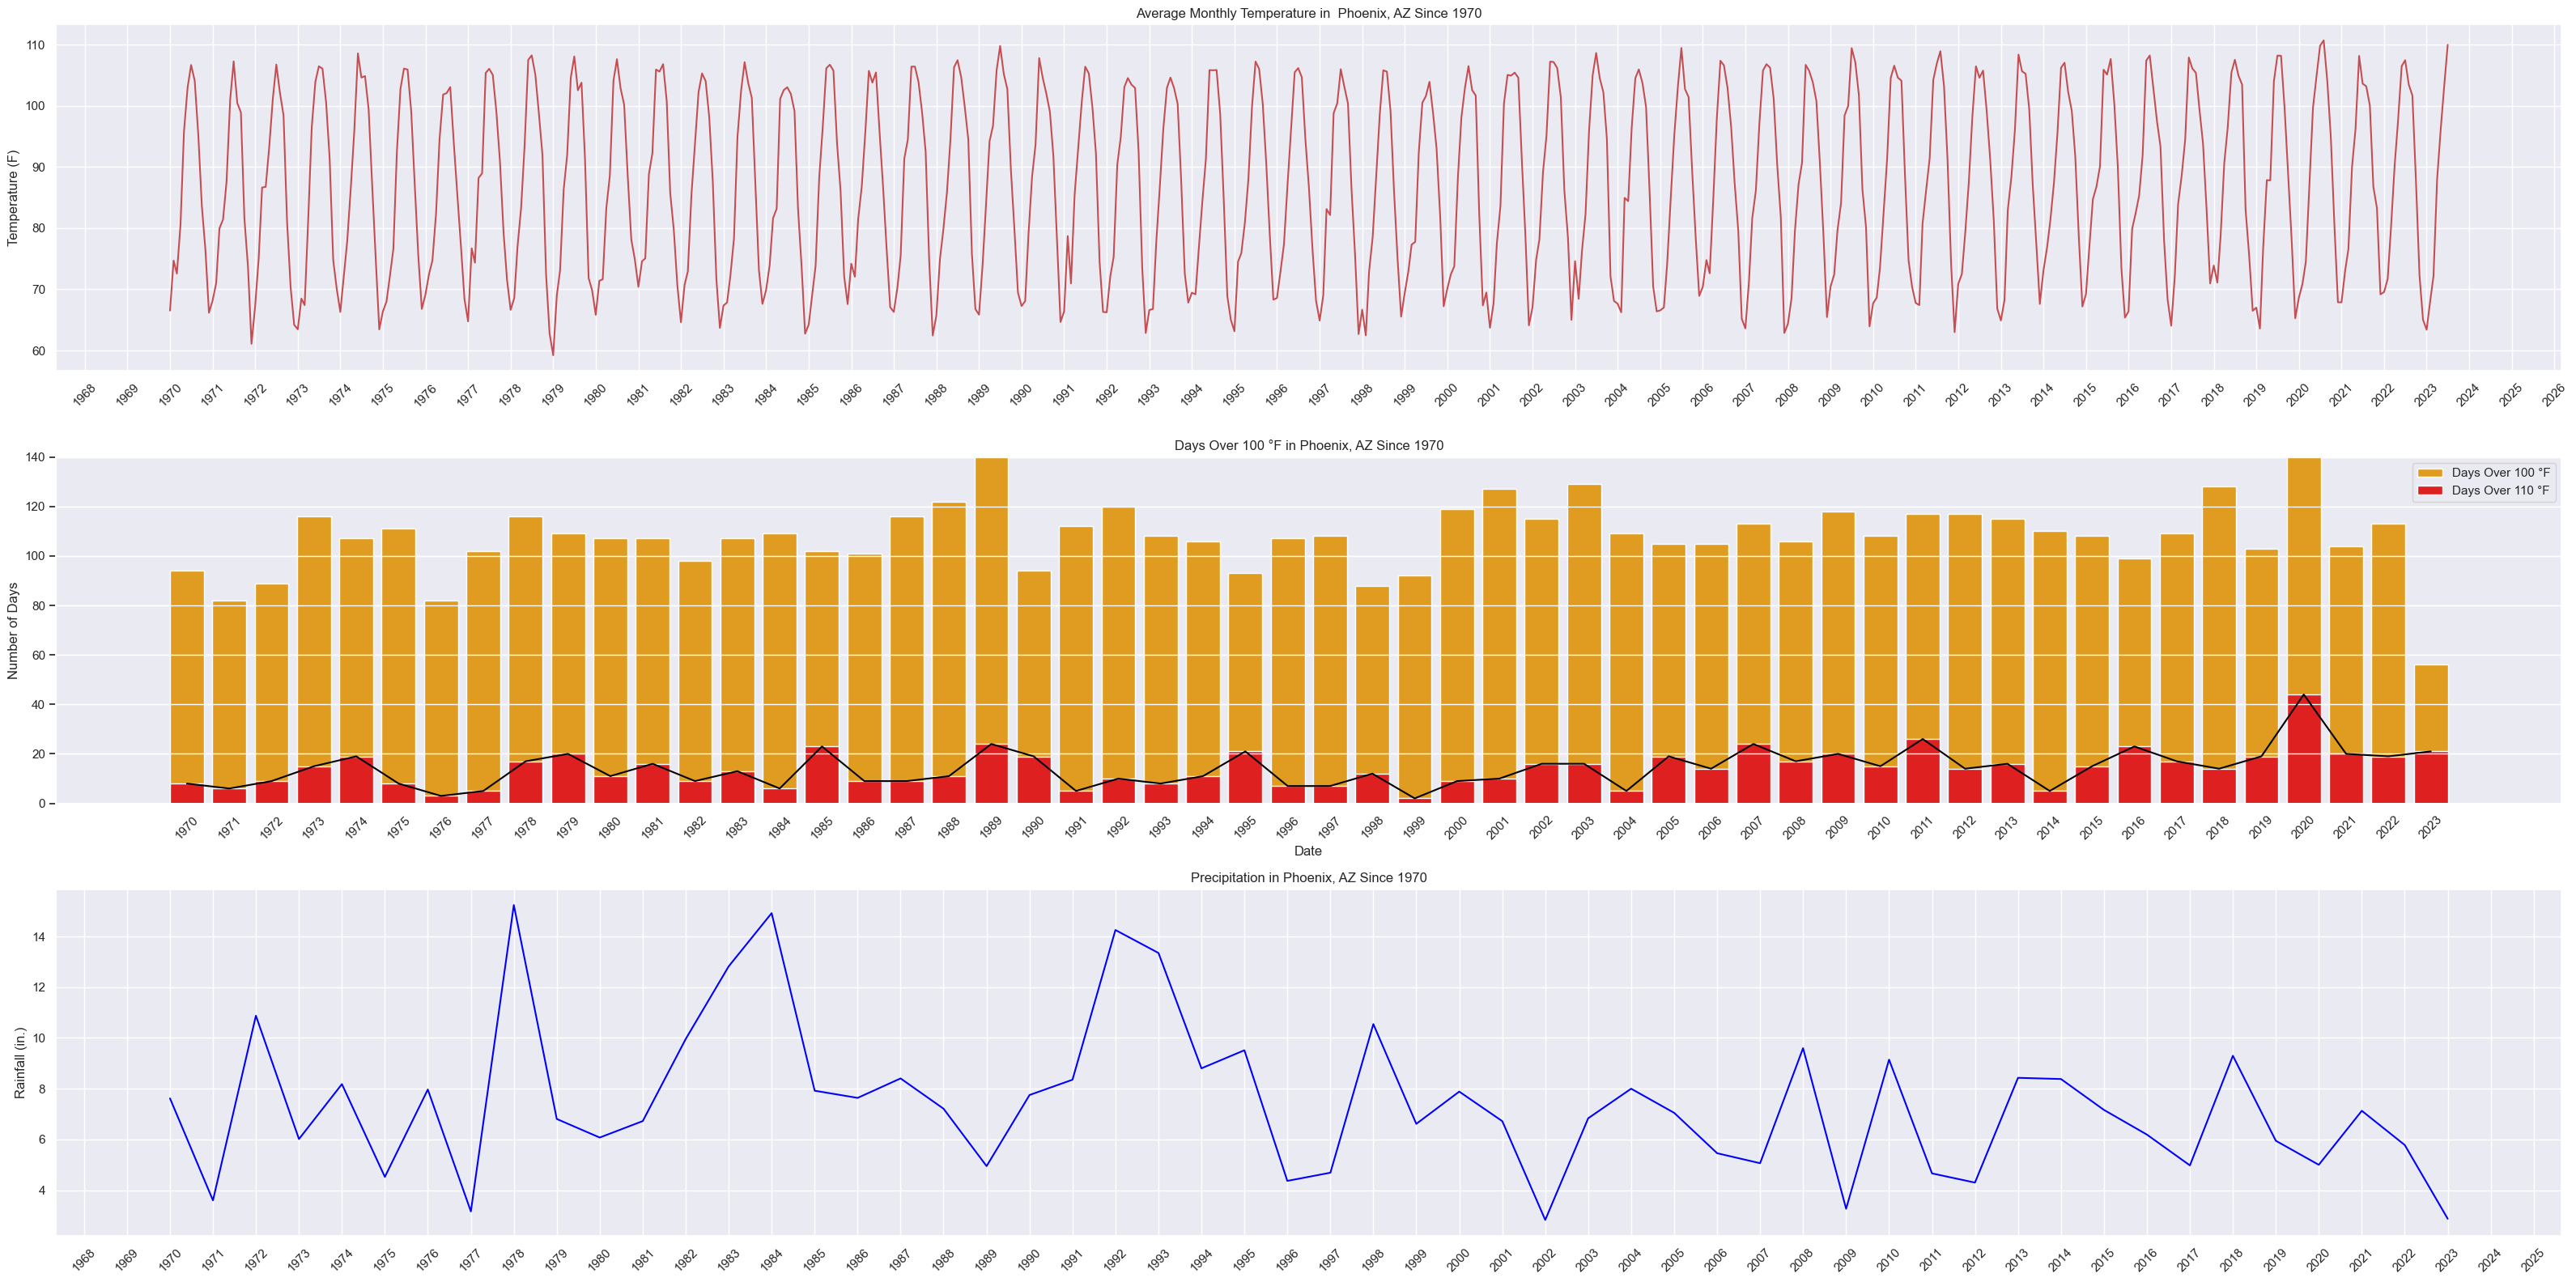

In [32]:
# Use seaborn to make the graphs look nicer
sns.set(style='darkgrid')
sns.set_palette('Reds')
# Create the figure and subplots
fig, (climate_ax, hundreds_ax, precipitation_ax) = plt.subplots(3, 1, figsize=(32, 16))
# Plot the climate data since 1970
climate_ax.plot(average_temps['Date'], average_temps['Temp_F'], 'r')
climate_ax.set_title('Average Monthly Temperature in  Phoenix, AZ Since 1970')
climate_ax.xaxis.set_major_locator(YearLocator())
climate_ax.xaxis.set_major_formatter(DateFormatter("%Y"))
climate_ax.tick_params('x', rotation=45)
climate_ax.set_ylabel('Temperature (F)')
# Plot the number of days with 100+ temperatures since 1970
sns.barplot(data=hundred_temperatures, x='Date', y='Days_Over_100', label='Days Over 100 °F', color='orange', ax=hundreds_ax)
sns.barplot(data=hundred_temperatures, x='Date', y='Days_Over_110', label='Days Over 110 °F', color='red', ax=hundreds_ax)
hundreds_ax.tick_params('x', rotation=45)
hundreds_ax.set_ylabel('Number of Days')
hundreds_ax.set_title('Days Over 100 °F in Phoenix, AZ Since 1970')
hundreds_ax.set_ylim(0,140)
hundreds_ax.legend()
# Add a line to the bar plot for temperatures over 110
hundreds_ax_2 = hundreds_ax.twinx()
sns.lineplot(data=hundred_temperatures, x=hundreds_ax.get_xticks(), y='Days_Over_110', ax=hundreds_ax_2, color='black')
hundreds_ax_2.set_ylim(0,140)
hundreds_ax_2.tick_params(left=False, labelleft=False, top=False, labeltop=False,
                   right=False, labelright=False, bottom=False, labelbottom=False)
hundreds_ax_2.set_ylabel('')
# Plot the precipitation since 1970
precipitation_ax.plot(precipitation_count['Date'], precipitation_count['Precipitation_in'], color='blue')
precipitation_ax.tick_params('x', rotation=45)
precipitation_ax.set_ylabel('Rainfall (in.)')
precipitation_ax.set_title('Precipitation in Phoenix, AZ Since 1970')
precipitation_ax.xaxis.set_major_locator(YearLocator())
precipitation_ax.xaxis.set_major_formatter(DateFormatter("%Y"))

plt.tight_layout()
plt.show()

In [33]:
# Save the plot
fig.savefig('PhoenixWeatherTrends.png', dpi=300)